In [1]:
!nvidia-smi

Wed Dec  8 17:16:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   43C    P0    45W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import mad_std
import tensorflow.keras as tfk
#from sfh.datasets.mergers import tng100_images

In [4]:
#train_dset,test_dset = tfds.load('tng100_images', split=['train[:75%]','train[75%:]'])
train_dset,valid_dset,test_dset = tfds.load('tng100_images', split=['train[:75%]','train[75%:85%]','train[85%:]'])

2021-12-08 17:17:13.807292: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-08 17:17:14.449136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


In [ ]:
train_dset

In [ ]:
test_dset

In [ ]:
print("Test",len(test_dset))
print("Train",len(train_dset))
print("Train",len(valid_dset))

print("Total",len(train_dset)+len(test_dset)+len(valid_dset))

In [ ]:
for example in train_dset.take(2):
    plt.figure()
    plt.imshow(example["image"][:,:,1],cmap='gray')
    lbt=float(example["last_major_merger"])
    plt.title("Last major merger "+str("{:.1f}".format(lbt))+" Gyr ago"+"\n Galaxy ID "+str(int(example["object_id"])))

In [ ]:
float(example["last_major_merger"])

**Normalise images**

In [ ]:
# Let's collect a few examples to check their distributions
imgs=[]
for (batch, entry) in enumerate(train_dset.take(1000)):
    imgs.append(entry['image'])
imgs=np.array(imgs)

In [ ]:
#Check pixel distribution for a few images
for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist(imgs[:,:,:,i].flatten(),100, label=b)
plt.legend()
plt.yscale("log")
plt.ylabel("Number of pixels")
plt.xlabel("Values")
plt.title("Histogram of the pixel values in the first 300 images")

In [ ]:
# Let's evaluate the noise standard deviation in each band, and apply range 
# compression accordingly
scaling = []
mean=[]
for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist(imgs[:,:,:,i].flatten(),100, label=b,alpha=0.5,range=[-100,100]);
    sigma = mad_std(imgs[:,:,:,i].flatten())
    scaling.append(sigma)
    mean.append(np.mean(imgs[:,:,:,i].flatten()))
    plt.axvline(sigma, color='C%d'%i,alpha=0.5)
    plt.axvline(-sigma, color='C%d'%i,alpha=0.5)
plt.legend()
plt.yscale("log")

In [ ]:
# Let's have a look at this distribution if we rescale each band by the standard
# deviation
for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist((imgs[:,:,:,i].flatten()-mean[i])/scaling[i],100, label=b,alpha=0.5,range=[-10,20]);
plt.legend()
plt.title("Histogram of the pixel values after rescaling by the standard deviation")


In [ ]:
# a common approach for range compression is to apply arcsinh to suppress the
# high amplitude values
#Test with a compression factor manually adjusted
for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist(1/3*np.arcsinh((imgs[:,:,:,i].flatten()-mean[i])/scaling[i]*3),100,
           label=b, alpha=0.5);
plt.legend()
plt.yscale('log')
plt.title("Histogram of the pixel values after scaling by std and arcsinh")

In [5]:
# Using a mapping function to apply preprocessing to our data
def evaluate_scaling(train_dset):
    """
    Evaluates the standard deviation of the pixel values in each band g,r,i,z.
    Input: train_dset (tensforflow dataset): training datset on which we want to evaluate the scaling
    Output: scaling (np array): array containig the std in each band
            mean (np array): array containig the mean in each band
    """
    #Takes 100 images from wich the std will be estimated  
    imgs=[]
    for (batch, entry) in enumerate(train_dset.take(100)):
        imgs.append(entry['image'])
    imgs=np.array(imgs)
    #Computes the scaling
    mean=[]
    scaling = []
    for i,b in enumerate(['g', 'r', 'i', 'z']):
        sigma = mad_std(imgs[:,:,:,i].flatten())
        mean.append(np.mean(imgs[:,:,:,i].flatten()))
        scaling.append(sigma)
    return scaling,mean

def preprocessing(example):
    """
    Normalises the images from the original dataset, by dividing it by the std in each band and by appling arcsinh scaling.
    NB: scaling and mean are global variablse, as this notebook is made only for one particular example and cannot be generalized without changing the code
    NB: a compression factor for the arcsinh has been added to compress the values close to 0-1
    Input: example (dict): example from the tensorflow dataset
    Output: norm_img (np ndarray): normalised image
            example["last_major_merger"]: tf tensor containing the lookback time of the last major merger
            example["object_id"]: tf tensor containing the galaxy id        
    """
    img=example["image"]
    norm_img=1/3*tf.math.asinh((img-mean)/tf.constant(scaling)*3)
    
    #Normalises output by 13.6 (age of the Universe)
    example["last_major_merger"]/=13.6
    
    return norm_img,example["last_major_merger"]#,example["object_id"]

In [6]:
scaling,mean=evaluate_scaling(train_dset)
print(scaling,mean)

2021-12-08 17:17:15.252563: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[14.680999273652667, 33.26186043453564, 52.801574038812326, 42.99546433666246] [76.30004, 138.52695, 193.61807, 125.84229]


In [7]:
#Normalise the training dataset
norm_train_dset = train_dset.map(preprocessing)

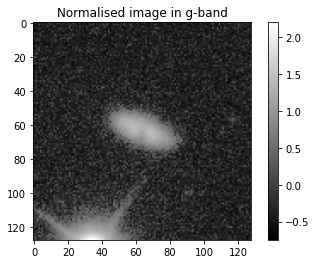

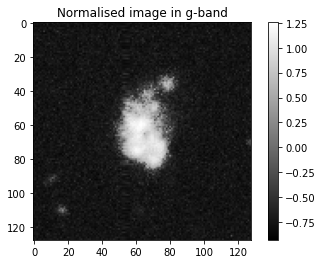

In [9]:
#Check the normalisation on a few examples
norm_imgs,last_major_merger,object_id=[],[],[]
for example in norm_train_dset.take(2):
    #print(np.shape(ex))
    plt.figure()
    norm_imgs.append(example[0])
    last_major_merger.append(float(example[1]))
    #object_id.append(int(example[2]))
    plt.imshow(norm_imgs[-1][:,:,0],cmap='gray')
    plt.title("Normalised image in g-band")
    plt.colorbar()

**Create the input pipeline**

In [10]:
def input_pipeline(mode='train', batch_size=64):
    """
    Creates the input pipeline that loads the dataset and normalises the data
    Possible modes: 'train', 'valid' or 'test'.
    Input: mode (str): specifies the mode for train, validation or test
           batch_size (int): size of the batch
    Output= dataset (tf dataset): properly processes dataset
    """
    if mode == 'train':
        dataset = tfds.load('tng100_images', split='train[:80%]')
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    elif mode=='valid':
        dataset = tfds.load('tng100_images', split='train[80%:90%]')
    elif mode=='test':
        dataset = tfds.load('tng100_images', split='train[90%:]')

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(preprocessing) # Apply data preprocessing
    dataset = dataset.prefetch(-1) # fetch next batches while training current one (-1 for autotune)
    return dataset

In [11]:
input_train_dset=input_pipeline(mode='train', batch_size=64)

In [12]:
input_train_dset

<PrefetchDataset shapes: ((64, 128, 128, 4), (64,)), types: (tf.float32, tf.float32)>

(64, 128, 128, 4)


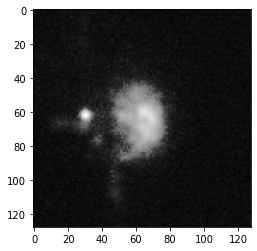

In [13]:
for example in input_train_dset.take(1):
    print(np.shape(example[0]))
    #plt.figure()
    plt.imshow(example[0][1,:,:,1],cmap='gray')

**Define a first simple CNN**

In [53]:
def build_model():
    
    model = tfk.models.Sequential()
    #1st layer
    model.add(tfk.layers.Conv2D(32, kernel_size=5, padding='same',input_shape=(128,128,4), activation='elu', strides=2))
    model.add(tfk.layers.BatchNormalization())
    #2nd layer
    model.add(tfk.layers.Conv2D(64, kernel_size=5, padding='same', activation='elu', strides=2))
    model.add(tfk.layers.BatchNormalization())
    #3rd layer
    model.add(tfk.layers.Conv2D(128, kernel_size=5, padding='same', activation='elu', strides=2))
    model.add(tfk.layers.BatchNormalization())
    #Flatten layer
    model.add(tfk.layers.Flatten())
    #Dense
    #model.add(tfk.layers.Dense(512,activation='relu'))
    model.add(tfk.layers.Dense(256,activation='relu'))
    model.add(tfk.layers.Dropout(0.3))
    model.add(tfk.layers.Dense(128,activation='relu'))
    
    model.add(tfk.layers.Dense(1,activation='relu'))
    model.compile(optimizer=tfk.optimizers.Adam(), # learning rate will be set by LearningRateScheduler
                loss=tfk.metrics.mse,
                metrics=["acc"])
    return model

In [54]:
model=build_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        3232      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)            

In [55]:
#Input dataset
dataset_training=input_pipeline(mode='train', batch_size=64)
dataset_validation=input_pipeline(mode='valid', batch_size=64)

In [56]:
#for ex in dataset_training.take(1):
#    plt.imshow(ex[0][1,:,:,1])

In [18]:
#len(dataset_training)#in batch

In [ ]:
#mins,maxs=[],[]
#for ex in dataset_training.take(len(dataset_training)):
#    mins.append(np.min(ex[0][:,:,:0].flatten()))
#    maxs.append(np.max(ex[0][:,:,:0].flatten()))    

In [ ]:
#Train the model
"""
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tfk.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
tb_callback = tf.keras.callbacks.TensorBoard('./logs/run2', update_freq='batch')"""

# We are ready to train our model
history=model.fit(dataset_training,
          validation_data=dataset_validation,
          steps_per_epoch=10000//64,
          epochs=10)#,
          #callbacks=[lr_decay, tb_callback])



Epoch 1/10
156/156 [==============================] - 5s 21ms/step - loss: 2.7070 - acc: 0.0000e+00 - val_loss: 0.5237 - val_acc: 0.0000e+00
Epoch 2/10
156/156 [==============================] - 3s 20ms/step - loss: 0.5336 - acc: 0.0000e+00 - val_loss: 0.5237 - val_acc: 0.0000e+00
Epoch 3/10
156/156 [==============================] - 3s 20ms/step - loss: 0.5318 - acc: 0.0000e+00 - val_loss: 0.5237 - val_acc: 0.0000e+00
Epoch 4/10
156/156 [==============================] - 3s 20ms/step - loss: 0.5317 - acc: 0.0000e+00 - val_loss: 0.5237 - val_acc: 0.0000e+00
Epoch 5/10
156/156 [==============================] - 3s 20ms/step - loss: 0.5300 - acc: 0.0000e+00 - val_loss: 0.5237 - val_acc: 0.0000e+00
Epoch 6/10
 82/156 [==============>...............] - ETA: 1s - loss: 0.5402 - acc: 0.0000e+00

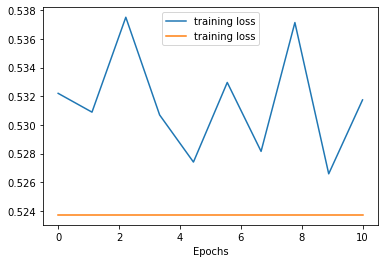

In [52]:
history.history.keys()
loss=history.history["loss"]
val_loss=history.history["val_loss"]
acc=history.history["acc"]

epochs=np.linspace(0,10,len(loss))
plt.plot(epochs,loss,label='training loss')
plt.plot(epochs,val_loss,label='training loss')
plt.xlabel("Epochs")
plt.legend()

